In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import os
import urllib.request  # fetch images from an url


from IPython.display import display, HTML, Markdown  # exclusive for jupyter notebook
from tqdm import tqdm  # Very cool progress bar :D
from typing import List, Tuple  # Explicit type, better explanation of the arguments without comments
from collections import Counter

from sklearn import preprocessing

In [91]:
plt.style.use('seaborn')

def display_markdown(*args, **kargs):
    display(Markdown(*args, **kargs))

In [92]:
fname = 'a943287.csv'
df = pd.read_csv(fname)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [93]:
X = df['image_url'].values
y = np.array(df['please_select_the_gender_of_the_person_in_the_picture'].values)

X[:5], y[:5]

(array(['https://d1qb2nb5cznatu.cloudfront.net/users/40-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/42-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/44-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/47-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/50-large'],
       dtype=object),
 array(['male', 'male', 'male', 'male', 'male'], dtype=object))

In [94]:

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X[:5], y[:5]

(array(['https://d1qb2nb5cznatu.cloudfront.net/users/40-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/42-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/44-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/47-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/50-large'],
       dtype=object), array([1, 1, 1, 1, 1]))

In [95]:
le.inverse_transform(y)

array(['male', 'male', 'male', ..., 'unsure', 'male', 'male'],
      dtype=object)

(array([ 7367.,     0.,     0.,     0.,     0., 47595.,     0.,     0.,
            0.,  9122.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

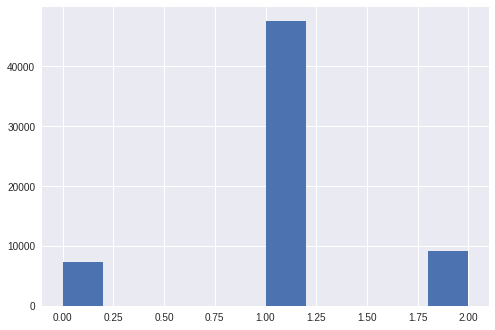

In [96]:
counter = Counter(y)
plt.hist(y, bins=10)

In [97]:
indexes = list(filter(lambda x: x == 2, range(len(y))))  # remove unknown figures
X = np.delete(X, indexes)
y = np.delete(y, indexes)

In [104]:

def make_dir(folder: str) -> None:
    if not os.path.exists(folder):
        os.mkdir(folder)
        
make_dir('img')
make_dir(os.path.join('img', 'male'))
make_dir(os.path.join('img', 'female'))
    
MALE_LABEL = 1
FEMALE_LABEL = 0

def save_img(img_url: str, filepath: str) -> None:
    try:
        with urllib.request.urlopen(img_url) as url:
            s = url.read()
            with open(filepath, 'wb') as f:
                f.write(s)
    except Http:
        pass  # image not found
    
def save_images_randomly(k: int, img_urls: list, seed=None):
    random.seed(seed)
    sublist = random.sample(population=list(img_urls), k=k)
    for i, img_url in tqdm(enumerate(sublist)): 
        save_img(img_url, f'{i}.jpg') 


In [105]:
def download_males_females(urls: List[str], labels: List[int], n: int, seed=None) -> None:
    counter = Counter(labels)
    n = min(min(counter[0], counter[1]), n)
    indexes = list(range(len(labels)))
    male_indexes = []
    female_indexes = []
    random.shuffle(indexes)
    i = 0
    while len(male_indexes) < n and len(female_indexes) < n:
        male_indexes.append(i) if labels[i] == MALE_LABEL else female_indexes.append(i)
        i += 1
    while len(male_indexes) < n: male_indexes.append(i); i += 1
    while len(female_indexes) < n: female_indexes.append(i); i += 1
    for i, j in zip(male_indexes, female_indexes):
        print(f'{i}/{len(male_indexes)}')
        save_img(urls[i], os.path.join('img', 'male', f'{i}.jpg'))
        save_img(urls[j], os.path.join('img', 'female', f'{j}.jpg'))
 

download_males_females(X, y, 25)
        

0/25
1/25
2/25
3/25
4/25
5/25
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25


NameError: name 'Http' is not defined

In [101]:
i = 60
print(X[i], y[i])

https://d1qb2nb5cznatu.cloudfront.net/users/512-large 1
